# Libraries

In [51]:
import os
from pathlib import Path
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
import scipy
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

In [52]:
features_path = Path.cwd()
notebooks_path = features_path.parent
repo_path = notebooks_path.parent
os.chdir(str(features_path))
#print current working directory
print(notebooks_path)

/home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte/Machine_Learning/notebooks


# Functions and classes

In [53]:
class path_label():
    """Class to access paths and labels from csv
    """
    def __init__(self, meta=pd.read_csv(str(repo_path) + '/data/meta_info.csv', sep='\t'), classif='binary', set_name='train') -> None:
        meta = meta.loc[meta['classif'] == classif] #Filter by classif
        meta = meta.loc[meta['set'] == set_name] #Filter by set
        self.paths = list(meta.path)
        self. labels = np.array(meta.label)
        self.FOV_x1 = np.array(meta.FOV_x1, dtype=np.int16)
        self.FOV_x2 = np.array(meta.FOV_x2, dtype=np.int16)
        self.FOV_y1 = np.array(meta.FOV_y1, dtype=np.int16)
        self.FOV_y2 = np.array(meta.FOV_y2, dtype=np.int16)

In [54]:
def save_pickle(file, filename):
    """save as pickle

    Args:
        file (obj): object to save
        filename (str): path of the object to save
    """
    with open(filename, 'wb') as handle:
        pickle.dump(file, handle, pickle.HIGHEST_PROTOCOL)

def open_pickle(filename):
    """open pickle file

    Args:
        filename (str): path of pickle file

    Returns:
        obj: object extracted form pickle
    """
    with open(filename, 'rb') as handle:
        return pickle.load(handle)

In [55]:
def classifier(method, grid_type='normal', scaler=StandardScaler(), reductor_components = [0.99], verbose=4):
    """get pipe and grid for classifier

    Args:
        method (str): classifier name
        scaler (scikit object, optional): type of scaler. Defaults to StandardScaler().
        verbose (int, optional): verbose level. Defaults to 4.

    Returns:
        _type_: _description_
    """
   #KNN
    if(method=='KNN'):
        param_grid = {'classifier__n_neighbors': list(range(1,40))}
        pipe = Pipeline([('scaler', scaler),('classifier',KNeighborsClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe
    if(method=='KNN_PCA'):
        param_grid = {'reductor__n_components': reductor_components, 'classifier__n_neighbors': list(range(1,40))}
        pipe = Pipeline([('scaler', scaler),('reductor',PCA()), ('classifier',KNeighborsClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe
    #RF
    elif(method=='RF'):
        param_grid = {'classifier__n_estimators': [100, 200, 400]}
        pipe = Pipeline([('scaler', scaler),('classifier',RandomForestClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe
    
    elif(method=='RF_PCA'):
        param_grid = {'reductor__n_components': reductor_components,'classifier__n_estimators': [100, 200, 400],}
        pipe = Pipeline([('scaler', scaler),('reductor',PCA()), ('classifier',RandomForestClassifier())])
        grid = GridSearchCV(pipe, param_grid, scoring='accuracy', verbose = verbose)
        return grid, pipe
    #SVM
    elif(method=='SVM'):
        if(grid_type=='normal'):
            param_grid = {'classifier__C': [7,8, 9, 10, 11],
                    'classifier__gamma': [0.008, 0.009, 0.01, 0.011],
                    'classifier__kernel': ['rbf'],'classifier__class_weight':['balanced']}
            pipe = Pipeline([('scaler', scaler),('classifier',SVC())])
            grid = GridSearchCV(pipe, param_grid, scoring='accuracy', verbose = verbose)
            return grid, pipe
        elif(grid_type=='random'):
            parameters = {'classifier__C': scipy.stats.expon(scale=10), 'classifier__gamma': scipy.stats.expon(scale=.1), #Parameters for grid search
            'classifier__kernel': ['rbf'], 'classifier__class_weight':['balanced']}
            pipe = Pipeline([('scaler', scaler),('classifier',SVC())]) #Definition of pipeline
            grid = RandomizedSearchCV(pipe, parameters,n_iter=20, scoring='accuracy', verbose=verbose, return_train_score=False) #Random search
            return grid, pipe
    elif(method=='SVM_PCA'):
        if(grid_type=='normal'):
            param_grid = {'reductor__n_components': reductor_components, 'classifier__C': [0.1, 1, 10, 100],
                    'classifier__gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                    'classifier__kernel': ['rbf'],'classifier__class_weight':['balanced']}
            pipe = Pipeline([('scaler', scaler),('reductor',PCA()), ('classifier',SVC())])
            grid = GridSearchCV(pipe, param_grid, scoring='accuracy', verbose = verbose)
            return grid, pipe
        elif(grid_type=='random'):
            parameters = {'reductor__n_components': reductor_components, 'classifier__C': scipy.stats.expon(scale=10), 'classifier__gamma': scipy.stats.expon(scale=.001), #Parameters for grid search
            'classifier__kernel': ['rbf'], 'classifier__class_weight':['balanced']}
            pipe = Pipeline([('scaler', scaler),('reductor',PCA()), ('classifier',SVC())]) #Definition of pipeline
            grid = RandomizedSearchCV(pipe, parameters,n_iter=100, scoring='accuracy', verbose=verbose, return_train_score=False) #Random search
            return grid, pipe
    #ADA
    elif(method=='AdaBoost'):
        param_grid = {'classifier__n_estimators': [50,100, 200, 400], 'classifier__learning_rate': [ 0.1, 1,5, 10]}
        pipe = Pipeline([('scaler', scaler),('classifier',AdaBoostClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe
    elif(method=='AdaBoost_PCA'):
        param_grid = {'reductor__n_components': reductor_components, 'classifier__n_estimators': [50,100, 200, 400], 'classifier__learning_rate': [ 0.1, 1,5, 10]}
        pipe = Pipeline([('scaler', scaler),('reductor',PCA()),('classifier',AdaBoostClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe
    #GradientBoosting
    elif(method=='GradBoost'):
        param_grid = {'classifier__learning_rate': [0.01, 0.1, 1, 10], 'classifier__max_iter': [100, 200, 400]}
        pipe = Pipeline([('scaler', scaler), ('classifier',GradientBoostingClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe


# IMP

In [56]:
def color_data_load(classif, color_space, f_name, NH = True):
    # Read train and valiadation data
    meta = pd.read_csv(str(repo_path) + '/data/meta_info.csv', sep='\t') #For labels
    f_type = 'color'

    #We read the training data
    if NH == False:
        X_train = open_pickle(str(repo_path)+ f'/data/features/{f_type}/{color_space}/{classif}_train_{f_type}_{f_name}_fv.p')
    else:
        X_train = open_pickle(str(repo_path)+ f'/data/features/{f_type}/{color_space}/{classif}_train_{f_type}_{f_name}_NH_fv.p')
    y_train = path_label(meta, classif, set_name='train').labels
    #Print shapes to be sure that dimensions are the same
    print(f'The shape of the training data is {X_train.shape} and its labels are {y_train.shape}')

    #We read the validation data
    if NH == False:
        X_val = open_pickle(str(repo_path)+ f'/data/features/{f_type}/{color_space}/{classif}_val_{f_type}_{f_name}_fv.p')
    else:
        X_val = open_pickle(str(repo_path)+ f'/data/features/{f_type}/{color_space}/{classif}_val_{f_type}_{f_name}_NH_fv.p')
    y_val = path_label(meta, classif, set_name='val').labels
    print(f'The shape of the valdiation data is {X_val.shape} and its labels are {y_val.shape}')
    
    return X_train, X_val, y_train, y_val

In [57]:
def texture_data_load(classif, f_name, NH = True):
    # Read train and valiadation data
    meta = pd.read_csv(str(repo_path) + '/data/meta_info.csv', sep='\t') #For labels
    f_type = 'texture'
    if NH == False:
        X_train = open_pickle(str(repo_path) + f'/data/features/{f_type}/{classif}_train_{f_type}_{f_name}_fv.p')
    else:
        X_train = open_pickle(str(repo_path) + f'/data/features/{f_type}/{classif}_train_{f_type}_{f_name}_NH_fv.p')
    y_train = path_label(meta, classif, set_name='train').labels
    if isinstance(X_train, list):
        X_train = np.array(X_train)
    #Print shapes to be sure that dimensions are the same
    print(f'The shape of the training data is {X_train.shape} and its labels are {y_train.shape}')
    
    #We read the validation data
    if NH == False:
        X_val = open_pickle(str(repo_path) + f'/data/features/{f_type}/{classif}_val_{f_type}_{f_name}_fv.p')
    else:
        X_val = open_pickle(str(repo_path) + f'/data/features/{f_type}/{classif}_val_{f_type}_{f_name}_NH_fv.p')
    y_val = path_label(meta, classif, set_name='val').labels
    if isinstance(X_val, list):
        X_val = np.array(X_val)
    print(f'The shape of the valdiation data is {X_val.shape} and its labels are {y_val.shape}')
    
    return X_train, X_val, y_train, y_val

## Data load

In [58]:
def get_Train_Val_Data(classif, c_name, t_name, NH = True):
    #Color data load
    color_space = 'RGB'  #To locate feature matrices
    c = color_data_load(classif, color_space, c_name, NH) #Get data
    #Texture data load
    if t_name==None:
        t = None
        return c
    else:
        t = texture_data_load(classif, t_name, NH)

    #Stack together
    X_train = np.hstack((c[0], t[0]))
    X_val = np.hstack((c[1], t[1]))
    y_train = c[2]
    y_val = c[3]
    print(f'The shape of the training data is {X_train.shape} and its labels are {y_train.shape}')
    print(f'The shape of the valdiation data is {X_val.shape} and its labels are {y_val.shape}')
    
    return X_train, X_val, y_train, y_val

In [59]:
classif = 'binary'
c_name = 'ColorStats'
#c_name = 'hist_256_fv_noFOV'
t_name = 'All_texture'
X_train, X_val, y_train, y_val = get_Train_Val_Data(classif, c_name, t_name, NH=False)

The shape of the training data is (15195, 54) and its labels are (15195,)
The shape of the valdiation data is (3796, 54) and its labels are (3796,)
The shape of the training data is (15195, 75) and its labels are (15195,)
The shape of the valdiation data is (3796, 75) and its labels are (3796,)
The shape of the training data is (15195, 129) and its labels are (15195,)
The shape of the valdiation data is (3796, 129) and its labels are (3796,)


## Training and testing

In [60]:
grid, pipe = classifier('SVM', grid_type='normal', scaler=StandardScaler(), verbose=4)
model = grid.fit(X_train,y_train)
save_pickle(model, str(repo_path) + f'/data/models/{classif}_{pipe.steps[-1][-1]}_{c_name}_{t_name}.p') #Save model
y_pred = model.predict(X_val) #predict
acc = np.mean(y_pred == y_val) #accuracy
print(acc)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END classifier__C=7, classifier__class_weight=balanced, classifier__gamma=0.008, classifier__kernel=rbf;, score=0.861 total time=   9.1s
[CV 2/5] END classifier__C=7, classifier__class_weight=balanced, classifier__gamma=0.008, classifier__kernel=rbf;, score=0.842 total time=   9.0s
[CV 3/5] END classifier__C=7, classifier__class_weight=balanced, classifier__gamma=0.008, classifier__kernel=rbf;, score=0.782 total time=   7.9s
[CV 4/5] END classifier__C=7, classifier__class_weight=balanced, classifier__gamma=0.008, classifier__kernel=rbf;, score=0.727 total time=  13.3s
[CV 5/5] END classifier__C=7, classifier__class_weight=balanced, classifier__gamma=0.008, classifier__kernel=rbf;, score=0.763 total time=  11.4s
[CV 1/5] END classifier__C=7, classifier__class_weight=balanced, classifier__gamma=0.009, classifier__kernel=rbf;, score=0.858 total time=  10.8s
[CV 2/5] END classifier__C=7, classifier__class_weight=balance

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82      1865
         1.0       0.83      0.83      0.83      1931

    accuracy                           0.83      3796
   macro avg       0.83      0.83      0.83      3796
weighted avg       0.83      0.83      0.83      3796



/home/ricardino/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


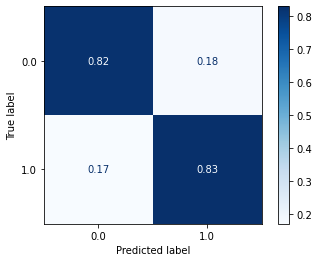

In [61]:
print(classification_report(y_val, y_pred))
#scores = cross_val_score(model, X_val, y_val, cv=5)
plot_confusion_matrix(model, X_val, y_val, cmap=plt.cm.Blues, normalize='true')

In [62]:
model.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 SVC(C=10, class_weight='balanced', gamma=0.009))])

In [63]:
pipe2 = pipe = Pipeline([('scaler', StandardScaler()),('classifier',SVC(C = 8, gamma = 0.011, kernel = 'rbf'))])
model = pipe2.fit(X_train,y_train)
y_pred = model.predict(X_val) #predict
acc = np.mean(y_pred == y_val) #accuracy
print(acc)

0.8287671232876712
